In [9]:
from sympy import symbols, cos, sin, solve, Eq
from sympy import nsolve, pi

# Assign some values (example)
l1_val = 1.0
l2_val = 1.0

x_val = 1.0
y_val = 1.0

# Substitute into the equations
eq1 = Eq(l1_val * cos(theta1) + l2_val * cos(theta1 + theta2), x_val)
eq2 = Eq(l1_val * sin(theta1) + l2_val * sin(theta1 + theta2), y_val)

# Provide a guess for the solution
initial_guess = (0.5, 0.5)
sol = nsolve((eq1, eq2), (theta1, theta2), initial_guess)
print(f"theta1 = {sol[0]}")
print(f"theta2 = {sol[1]}")




theta1 = -3.91857697863778E-23
theta2 = 1.57079632679490


In [ ]:
from sympy import symbols, acos, atan2, cos, sin, deg, N

def inverse_kinematics_2link_degrees(x_val, y_val, l1_val, l2_val):
    # Declare symbols
    l1, l2, x, y = symbols('l1 l2 x y', real=True, positive=True)

    # Law of cosines for theta2
    cos_theta2 = (x**2 + y**2 - l1**2 - l2**2) / (2 * l1 * l2)
    theta2_pos = acos(cos_theta2)
    theta2_neg = -acos(cos_theta2)

    # Geometry for theta1 (elbow-down)
    k1_pos = l1 + l2 * cos(theta2_pos)
    k2_pos = l2 * sin(theta2_pos)
    theta1_pos = atan2(y, x) - atan2(k2_pos, k1_pos)

    # Geometry for theta1 (elbow-up)
    k1_neg = l1 + l2 * cos(theta2_neg)
    k2_neg = l2 * sin(theta2_neg)
    theta1_neg = atan2(y, x) - atan2(k2_neg, k1_neg)

    # Substitute numeric values and convert to degrees
    subs = {x: x_val, y: y_val, l1: l1_val, l2: l2_val}
    theta1_pos_deg = N(deg(theta1_pos.subs(subs)))
    theta2_pos_deg = N(deg(theta2_pos.subs(subs)))
    theta1_neg_deg = N(deg(theta1_neg.subs(subs)))
    theta2_neg_deg = N(deg(theta2_neg.subs(subs)))

    return {
        'elbow_down': (theta1_pos_deg, theta2_pos_deg),
        'elbow_up': (theta1_neg_deg, theta2_neg_deg)
    }

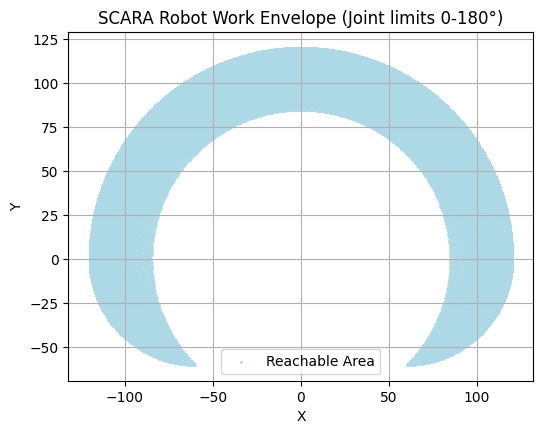

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_scara_workspace(l1, l2):
    """
    Draws the work envelope (reachable area) for a 2-link SCARA robot arm,
    with both joints limited to 0-180 degrees (0 to pi radians).
    At full extension, the elbow joint (theta2) is 90 degrees,
    with a range from 0 to 180 degrees.
    """
    # Joint ranges in radians
    theta1_range = np.linspace(0, np.pi, 200)
    theta2_range = np.linspace(0, np.pi, 200)

    # Meshgrid for all combinations
    T1, T2 = np.meshgrid(theta1_range, theta2_range)

    # Forward kinematics
    X = l1 * np.cos(T1) + l2 * np.cos(T1 + T2 - np.pi/2)
    Y = l1 * np.sin(T1) + l2 * np.sin(T1 + T2 - np.pi/2)

    # Plotting
    plt.figure(figsize=(6,6))
    plt.scatter(X, Y, s=1, color='lightblue', label='Reachable Area')
    plt.gca().set_aspect('equal')
    plt.title("SCARA Robot Work Envelope (Joint limits 0-180°)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

draw_scara_workspace(60, 60)